# 노말데이터로 학습 진행 
# 모델 : EfficientNetB5

In [ ]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs =50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [ ]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "/Users/krc/Documents/이어드림 수업/딥러닝_컴퓨터비전(CV)_Project/Project_cancer_file/ZCASD_Origin_file/"

train_directory = CurrentDirectory + 'Train/'
test_directory  = CurrentDirectory + 'Test/'
model_directory = CurrentDirectory + 'Model/'
# tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [ ]:
# 모델 Return
EfficientNetB5_model = tf.keras.applications.EfficientNetB5(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
# 마지막 prediction layer를 위한 작업

x = GlobalAveragePooling2D()(EfficientNetB5_model.output)
predictions = Dense(2, activation='softmax')(x)
# predictions = Dense(2, activation='sigmoid')(x)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs=EfficientNetB5_model.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=Decay, amsgrad=False), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

/Users/krc/miniforge3/envs/tf_CPU/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.20) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
datagen_test = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")




# Generator의 instance 생성 (Train)
train_generator = datagen_train.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

valid_generator = datagen_train.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
test_generator = datagen_test.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 7158 images belonging to 2 classes.
Found 1788 images belonging to 2 classes.
Found 2232 images belonging to 2 classes.


In [ ]:
DeepLearning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='ZCASD_Model/0802_B5_1/{epoch:03d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# tensorboard
TB = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=2, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [ ]:
# ######### Training Start
# DeepLearning.fit(train_generator, 
#                  epochs=20, 
#                  callbacks=CALLBACK,
#                  shuffle=True, 
#                  validation_data=valid_generator)

/Users/krc/miniforge3/envs/tf_CPU/lib/python3.8/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/krc/miniforge3/envs/tf_CPU/lib/python3.8/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


2022-08-02 10:36:45.503127: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


252/252 [==============================] - ETA: 0s - loss: 0.4993 - acc: 0.7854
Epoch 1: val_acc improved from -inf to 0.78248, saving model to ZCASD_Model/0802_B5_1/001-0.4993-0.7854-0.5313-0.7825.hdf5
252/252 [==============================] - 2623s 10s/step - loss: 0.4993 - acc: 0.7854 - val_loss: 0.5313 - val_acc: 0.7825 - lr: 0.0010
Epoch 2/20
252/252 [==============================] - ETA: 0s - loss: 0.4298 - acc: 0.8222
Epoch 2: val_acc did not improve from 0.78248
252/252 [==============================] - 2261s 9s/step - loss: 0.4298 - acc: 0.8222 - val_loss: 0.5550 - val_acc: 0.7581 - lr: 0.0010
Epoch 3/20
252/252 [==============================] - ETA: 0s - loss: 0.4028 - acc: 0.8290
Epoch 3: val_acc improved from 0.78248 to 0.78845, saving model to ZCASD_Model/0802_B5_1/003-0.4028-0.8290-0.5167-0.7885.hdf5
252/252 [==============================] - 1938s 8s/step - loss: 0.4028 - acc: 0.8290 - val_loss: 0.5167 - val_acc: 0.7885 - lr: 0.0010
Epoch 4/20
252/252 [==============

0. Threshold (임의로 선택, youden's index: sensitivity + specificity 최대)
1. Accuracy (Threshold: 0.5에서 나눌건지.. 0.6에서 나눌건지..)
2. sensitivity (암 중에서 암이라고 예측한 것) TP
3. Specificity (정상 중에서 정상이라고 예측한 것) TN
4. ROC를 그리고 AUC 값 구하기 (넓이 = AUROC, AUC)
+@5 : Heatmap (Class Activation Map, Grad-CAM)

In [ ]:
deep_path = '/Users/krc/Documents/이어드림 수업/딥러닝_컴퓨터비전(CV)_Project/ZCASD_Model/0803_0804/'

DeepLearning.load_weights('/Users/krc/Documents/이어드림 수업/딥러닝_컴퓨터비전(CV)_Project/ZCASD_Model/0803_0804/b5012-0.2470-0.9025-0.4966-0.8333.hdf5')

In [ ]:
# 모델을 평가합니다
loss, acc = DeepLearning.evaluate(test_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

70/70 - 160s - loss: 10.0738 - acc: 0.8194 - 160s/epoch - 2s/step
훈련되지 않은 모델의 정확도: 81.94%


In [ ]:
Test_prediction = DeepLearning.predict_generator(test_generator, verbose=1)
result = pd.DataFrame(Test_prediction)

/var/folders/vl/3_6ksrvn7g56c54ypcf170ch0000gn/T/ipykernel_5987/2078965783.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Test_prediction = DeepLearning.predict_generator(test_generator, verbose=1)
/Users/krc/miniforge3/envs/tf_CPU/lib/python3.8/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/krc/miniforge3/envs/tf_CPU/lib/python3.8/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


70/70 [==============================] - 157s 2s/step


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

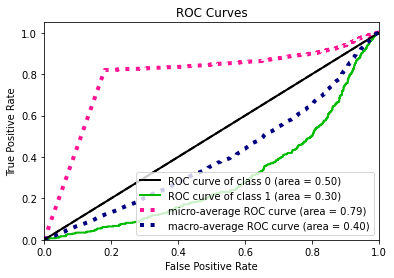

In [ ]:
skplt.metrics.plot_roc(test_generator.classes.tolist(), result)

In [ ]:
import PIL

def grad_cam(model, img, layer_name="block5_conv3", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        
        # wight 값
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="conv4_block6_out", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

In [ ]:
# CAM Generator
CAM_GENERATOR = datagen_test.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = 1,
    shuffle = False,
    class_mode='binary')

Found 2232 images belonging to 2 classes.


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


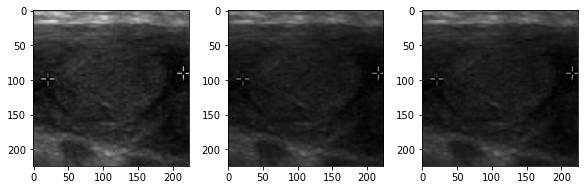

In [ ]:
Iterator = 1

# item 받아오기
Image, Label = test_generator.__getitem__(Iterator)
Image = Image[0]
print(Label)


# grad_cam을 활용하여 heatmap 가져오기
HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = 'top_conv', category_id=0)
heatmap_resize = cv2.resize(HEATMAP1, (224, 224))
heatmap_resize_255 = (heatmap_resize*255).astype("uint8")
heatmap1 = cv2.applyColorMap(255-heatmap_resize_255, cv2.COLORMAP_JET ) / 255
heatmap1[:, :, 2] -= .5
heatmap1[(heatmap1[:, :, 2] < 0), 2] = 0

fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
fig.set_size_inches(9.0, 3.0)
ax = plt.subplot(1,3,1)
ax.imshow(Image)
ax = plt.subplot(1,3,2)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
ax = plt.subplot(1,3,3)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
pred=round(pred1.numpy()[0][0],3)
plt.show()